4. Klasyfikacja

In [99]:
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np

4.1. Wczytanie przygotowanych danych z pliku

In [100]:
X_train_file = 'X_train.csv'
X_test_file = 'X_test.csv'
y_train_file = 'y_train.csv'
y_test_file = 'y_test.csv'
dates_file = 'dates.csv'

X_train = pd.read_csv(X_train_file)
X_test = pd.read_csv(X_test_file)
y_train = pd.read_csv(y_train_file)
y_test = pd.read_csv(y_test_file)
dates = pd.read_csv(dates_file)

In [101]:
y_train = y_train['bitcoin_trend']
y_test = y_test['bitcoin_trend']

In [102]:
print(f'Type of X_train: {type(X_train)}')
print(f'Type of y_train: {type(y_train)}')
print(f'Type of X_test: {type(X_test)}')
print(f'Type of y_test: {type(y_test)}')

Type of X_train: <class 'pandas.core.frame.DataFrame'>
Type of y_train: <class 'pandas.core.series.Series'>
Type of X_test: <class 'pandas.core.frame.DataFrame'>
Type of y_test: <class 'pandas.core.series.Series'>


In [103]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3121628 entries, 0 to 3121627
Data columns (total 1 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   text    object
dtypes: object(1)
memory usage: 23.8+ MB


W X_train pojawiły się nulle, czyszczenie

In [104]:
print(f'Nulle w X_train: {X_train.text.isna().sum()}')
print(f'Nulle w y_train: {y_train.isna().sum()}')
null_indexes_X_train = X_train[X_train['text'].isna()].index
X_train = X_train.drop(null_indexes_X_train)
y_train = y_train.drop(null_indexes_X_train)
print(X_train.shape)
print(y_train.shape)
print(f'Nulle w X_train: {X_train.text.isna().sum()}')
print(f'Nulle w y_train: {y_train.isna().sum()}')

Nulle w X_train: 4998
Nulle w y_train: 0
(3116630, 1)
(3116630,)
Nulle w X_train: 0
Nulle w y_train: 0


Klasyfikator 1: model baselinowy (losowanie wartości)

In [105]:
print(X_train.shape)
print(y_train.shape)

(3116630, 1)
(3116630,)


In [106]:
# Model baselinowy
from sklearn.dummy import DummyClassifier

# Klasyfikator losujący wartości z jednakowym prawdopodobieństwem
baseline_model = DummyClassifier(strategy='uniform', random_state=42)
baseline_model.fit(X_train, y_train)
baseline_model.score(X_test, y_test)

0.4996553565241195

In [107]:
# Ewaluacja modelu baselinowego
y_pred = baseline_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall =recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print('Recall:{:.2f}'.format(recall))
print("F1: {:.2f}".format(f1))

Accuracy: 0.50
Precision: 0.47
Recall:0.50
F1: 0.49


In [108]:
# Zapisanie modelu do pliku
filename = 'baseline_model.sav'
joblib.dump(baseline_model, filename)

['baseline_model.sav']

Wizualizacja modelu

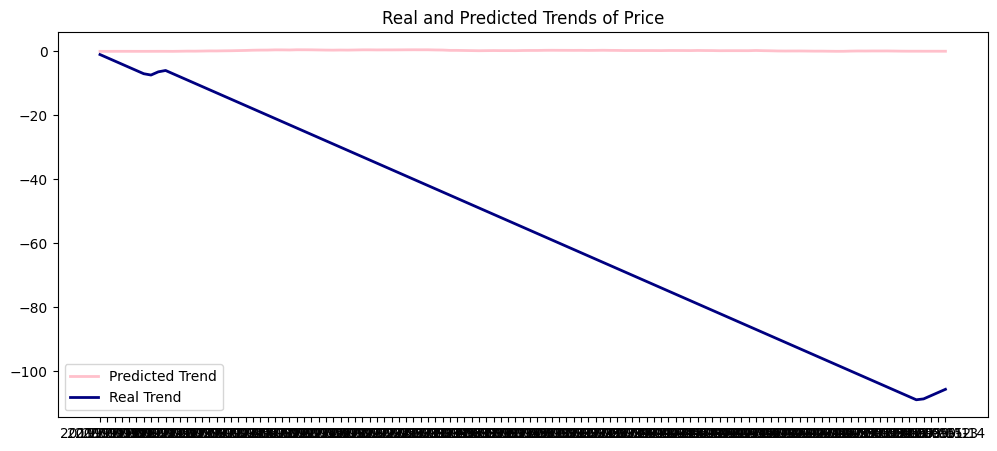

In [109]:
def prepare_plot_data(dates, y_pred, y_test):
    a = dates[len(dates)-len(y_pred):]
    b = pd.Series(y_pred)
    c = pd.Series(y_test)
    a.reset_index(drop=True, inplace=True)
    b.reset_index(drop=True, inplace=True)
    c.reset_index(drop=True, inplace=True)
    d = pd.concat([a,b],axis=1,ignore_index=True)
    e = pd.concat([a,c],axis=1,ignore_index=True)
    f = d.groupby([0]).mean()
    g = e.groupby([0]).mean()
    y_pred_plot = f[[1]].values
    y_test_plot = g[[1]].values
    dates_plot = f.index
    #print(y_pred_plot[:20])
    y_pred_plot_cumsum = y_pred_plot.cumsum()
    #print(y_pred_plot_cumsum[:40])

    return dates_plot, y_pred_plot.cumsum(), y_test_plot.cumsum()


def visualization_of_pred(dates, y_pred, y_test):
    dates_plot, y_pred_plot, y_test_plot = prepare_plot_data(dates, y_pred, y_test)
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(dates_plot, y_pred_plot, linewidth=2, label='Predicted Trend', color= 'pink')
    ax.plot(dates_plot, y_test_plot, linewidth=2, label='Real Trend', color = 'navy')
    plt.title('Real and Predicted Trends of Price')
    plt.legend()
    plt.show()

dates_pred = dates[len(dates)-len(y_pred):]
visualization_of_pred(dates_pred['Date'], y_pred, y_test)

Klasyfikator 2: regresja logistyczna

In [110]:
X_train[-2:]

,text
3121626,selcoin hocam eth btc gibi sert düzeltm yapmalimi
3121627,make sure updat wallet latest version v01605 e...


In [111]:
a = X_train[:7]._append(X_train[-2:])

In [112]:
a

,text
0,44700 0100 utc 24h rang 44357 46557 volum 1275...
1,btce price last 44400 bid 44400 ask 44400 vol ...
2,live profit 93928 055 buy b38220 45019 btce se...
3,45240 1715 utc 24h rang 45000 46940 volum 1045...
4,kqed enjoy littl gift xeniar sent bitcoin tip ...
5,last min arb opp span exchang pair yield profi...
6,45010 1730 utc 24h rang 45000 46940 volum 1046...
3121626,selcoin hocam eth btc gibi sert düzeltm yapmalimi
3121627,make sure updat wallet latest version v01605 e...


In [113]:
a.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 0 to 3121627
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9 non-null      object
dtypes: object(1)
memory usage: 144.0+ bytes


In [114]:
a = a['text'].tolist()

In [115]:
b = y_train[:7]._append(y_train[-2:])

In [116]:
from sklearn.feature_extraction.text import TfidfTransformer

logistic_regression_pipeline = Pipeline(steps=[
    ('count_vectorizer', CountVectorizer(lowercase=False)),
    #('tfidf_transformer', TfidfTransformer()),
    ('model', LogisticRegression())
])

In [117]:
logistic_regression_pipeline.fit(a,b)

Pipeline(steps=[('count_vectorizer', CountVectorizer(lowercase=False)),
                ('model', LogisticRegression())])

In [118]:
TfidfTransformer().fit_transform(a)

ValueError: Expected 2D array, got 1D array instead:
array=['44700 0100 utc 24h rang 44357 46557 volum 12759 btc'
 'btce price last 44400 bid 44400 ask 44400 vol 380719 btc bitcoin btce'
 'live profit 93928 055 buy b38220 45019 btce sell 45300 bitfinex bitcoin btc'
 '45240 1715 utc 24h rang 45000 46940 volum 10459 btc'
 'kqed enjoy littl gift xeniar sent bitcoin tip 2199 mbtc 100 come get'
 'last min arb opp span exchang pair yield profit rang 000 167489 bitcoin btc'
 '45010 1730 utc 24h rang 45000 46940 volum 10463 btc'
 'selcoin hocam eth btc gibi sert düzeltm yapmalimi'
 'make sure updat wallet latest version v01605 ensur correct data wallet hive mine 100 like result loss good luck wallet lcc hive btc crypto blockchain'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [121]:
len(a)

9

In [122]:
b.shape

(9,)

In [123]:
vectorizer = CountVectorizer()
# Dopasowanie i transformacja danych tekstowych
X = vectorizer.fit_transform(a)
# Konwersja do macierzy numpy
X_array = X.toarray()
# Wyświetlenie zmapowanych cech (słów) jako wektor
features = vectorizer.get_feature_names_out()
print("Zmapowane cechy (słowa):", features)
# Wyświetlenie macierzy liczebności
print("Macierz liczebności:")
print(X_array)

Zmapowane cechy (słowa): ['000' '0100' '055' '100' '10459' '10463' '12759' '167489' '1715' '1730'
 '2199' '24h' '380719' '44357' '44400' '44700' '45000' '45010' '45019'
 '45240' '45300' '46557' '46940' '93928' 'arb' 'ask' 'b38220' 'bid'
 'bitcoin' 'bitfinex' 'blockchain' 'btc' 'btce' 'buy' 'come' 'correct'
 'crypto' 'data' 'düzeltm' 'enjoy' 'ensur' 'eth' 'exchang' 'get' 'gibi'
 'gift' 'good' 'hive' 'hocam' 'kqed' 'last' 'latest' 'lcc' 'like' 'littl'
 'live' 'loss' 'luck' 'make' 'mbtc' 'min' 'mine' 'opp' 'pair' 'price'
 'profit' 'rang' 'result' 'selcoin' 'sell' 'sent' 'sert' 'span' 'sure'
 'tip' 'updat' 'utc' 'v01605' 'version' 'vol' 'volum' 'wallet' 'xeniar'
 'yapmalimi' 'yield']
Macierz liczebności:
[[0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 3 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 2 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0

In [124]:
a

['44700 0100 utc 24h rang 44357 46557 volum 12759 btc',
 'btce price last 44400 bid 44400 ask 44400 vol 380719 btc bitcoin btce',
 'live profit 93928 055 buy b38220 45019 btce sell 45300 bitfinex bitcoin btc',
 '45240 1715 utc 24h rang 45000 46940 volum 10459 btc',
 'kqed enjoy littl gift xeniar sent bitcoin tip 2199 mbtc 100 come get',
 'last min arb opp span exchang pair yield profit rang 000 167489 bitcoin btc',
 '45010 1730 utc 24h rang 45000 46940 volum 10463 btc',
 'selcoin hocam eth btc gibi sert düzeltm yapmalimi',
 'make sure updat wallet latest version v01605 ensur correct data wallet hive mine 100 like result loss good luck wallet lcc hive btc crypto blockchain']

In [125]:
CountVectorizer(lowercase=False).fit_transform(a)

<9x85 sparse matrix of type '<class 'numpy.int64'>'
	with 110 stored elements in Compressed Sparse Row format>

In [126]:
LogisticRegression().fit(a,b)

ValueError: could not convert string to float: '44700 0100 utc 24h rang 44357 46557 volum 12759 btc'

In [127]:
b = y_train[:7]

In [128]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3116630 entries, 0 to 3121627
Data columns (total 1 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   text    object
dtypes: object(1)
memory usage: 47.6+ MB


In [129]:
from sklearn.tree import DecisionTreeClassifier

logistic_regression_pipeline = Pipeline(steps=[
    ('count_vecotizer', CountVectorizer(min_df=0.05, max_df=0.8, ngram_range=(1, 3))),
    ('logistic_regression', DecisionTreeClassifier())
])

In [130]:
print(X_train.shape)
print(y_train.shape)

(3116630, 1)
(3116630,)


In [131]:
X_train

,text
0,44700 0100 utc 24h rang 44357 46557 volum 1275...
1,btce price last 44400 bid 44400 ask 44400 vol ...
2,live profit 93928 055 buy b38220 45019 btce se...
3,45240 1715 utc 24h rang 45000 46940 volum 1045...
4,kqed enjoy littl gift xeniar sent bitcoin tip ...
...,...
3121623,🔥📈🔥📈🔥📈🔥🙂🚀🌌
3121624,andimmut code prefer code natur suppli code ar...
3121625,satoshi websit bitcoin reveal even stupid imag...
3121626,selcoin hocam eth btc gibi sert düzeltm yapmalimi


Grid search

In [132]:
# Definicja parametrów do sprawdzenia
parameters = {
    'tfidf__max_features': [1000, 5000],  # Liczba najważniejszych cech
    'model__C': [0.1, 1, 10],  # Parametr regularyzacji
}

# Tworzenie pipeline'u z TfidfVectorizer i LogisticRegression
gridsearch_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', LogisticRegression())
])

# Utworzenie obiektu GridSearchCV z kroswalidacją uwzględniającą chronologię
grid_search = GridSearchCV(
    gridsearch_pipeline,
    parameters,
    cv=TimeSeriesSplit(n_splits=5)
)

# Dopasowanie modelu GridSearchCV do danych treningowych
grid_search.fit(X_train, y_train)

# Najlepsze znalezione parametry
best_params = grid_search.best_params_
print("Najlepsze parametry:", best_params)

# Ocena najlepszego modelu na danych testowych
accuracy = grid_search.score(X_test, y_test)
print("Dokładność na danych testowych:", accuracy)

# Utworzenie obiektu GridSearchCV
grid_search = GridSearchCV(estimator=test_pipe, param_grid=parameters, cv=5)

# Dopasowanie modelu grid search do danych
grid_search.fit(X_train['text'], y_train['bitcoin_trend'])

# Najlepsze parametry i wynik
print("Najlepsze parametry: ", grid_search.best_params_)
print("Najlepszy wynik: ", grid_search.best_score_)

ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1196, in fit
    X, y = self._validate_data(
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\utils\validation.py", line 1124, in check_X_y
    check_consistent_length(X, y)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\utils\validation.py", line 397, in check_consistent_length
    raise ValueError(
ValueError: Found input variables with inconsistent numbers of samples: [1, 519440]

--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1196, in fit
    X, y = self._validate_data(
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\utils\validation.py", line 1124, in check_X_y
    check_consistent_length(X, y)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\utils\validation.py", line 397, in check_consistent_length
    raise ValueError(
ValueError: Found input variables with inconsistent numbers of samples: [1, 1038878]

--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1196, in fit
    X, y = self._validate_data(
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\utils\validation.py", line 1124, in check_X_y
    check_consistent_length(X, y)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\utils\validation.py", line 397, in check_consistent_length
    raise ValueError(
ValueError: Found input variables with inconsistent numbers of samples: [1, 1558316]

--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1196, in fit
    X, y = self._validate_data(
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\utils\validation.py", line 1124, in check_X_y
    check_consistent_length(X, y)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\utils\validation.py", line 397, in check_consistent_length
    raise ValueError(
ValueError: Found input variables with inconsistent numbers of samples: [1, 2077754]

--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1196, in fit
    X, y = self._validate_data(
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\utils\validation.py", line 1124, in check_X_y
    check_consistent_length(X, y)
  File "C:\Users\atago\.conda\envs\newConda\lib\site-packages\sklearn\utils\validation.py", line 397, in check_consistent_length
    raise ValueError(
ValueError: Found input variables with inconsistent numbers of samples: [1, 2597192]


In [133]:
# Parametry do przetestowania w grid search
parameters = {
    'tfidf_vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf_vectorizer__min_df': [0.1, 0.2, 0.3],
    'tfidf_vectorizer__max_df': [0.5, 0.75, 1.0],
    'model__C': [0.1, 1, 10]
}

Klasyfikator 3: LSTM